In [ ]:
sdbb

In [ ]:
from zipfile import ZipFile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import numpy as np
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import os
import cv2
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
use_cuda = True
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = Path("/content/drive/My Drive/archive")
train_dir = data_dir / "train"
val_dir = data_dir / "test"
classes = ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to greyscale
    transforms.Resize((48, 48)),                  # Resize to 48x48
    transforms.ToTensor()                         # Convert to tensor
])
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionRecognition(nn.Module):
    def __init__(self, num_classes=6):
        super(EmotionRecognition, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 6 * 6)  # Flatten the tensor

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


model = EmotionRecognition(num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Get model name for checkpointing
def get_model_name(name, batch_size, learning_rate, epoch):
   path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size,
                                                  learning_rate, epoch)
   return path

In [ ]:

def get_accuracy(model, data_loader):
    #initialize counters
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        #Enable GPU if available
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    #Return accuracy
    return correct / total

In [ ]:
def plot_training_curve(path, num_epochs, train_acc, val_acc):
    plt.title("Training Curve")
    n = len(num_epochs) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train(model, train_loader, val_loader, batch_size=64, num_epochs=30,
          learn_rate=0.001, model_name='EmotionRecognition'):
    #Set seed
    torch.manual_seed(1700)

    #Set loss function and optimizer
    #I chose to use cross entropy loss for the loss function because
    #we have been taught that this is generally the best performing
    #loss function for multiclass classification problems.
    #I chose to use Adam as the optimizer because according to my
    #research, Adam generally provides very good results without
    #significant fine tuning.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    #populate accuracy arrays with zeroes
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    #initialize iteration counter
    n = 0
    for epoch in range(num_epochs):
        for images, labels in iter(train_loader):
            #Enable GPU if available
            if use_cuda and torch.cuda.is_available():
              images = images.cuda()
              labels = labels.cuda()

            #perform forwards pass
            out = model(images)
            #Compute loss using Cross Entropy loss function
            loss = criterion(out, labels)
            #backward pass to calculate and update parameters.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #increment iteration counter
            n += 1

        # track training and validation accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)

        #output accuracy
        print(("Epoch: {} | Training acc: {} |" + "Validation acc: {}"
        ).format(epoch, train_acc[epoch], val_acc[epoch]))

        #checkpoint model
        model_path = get_model_name(model_name, batch_size, learn_rate,
                                    epoch)
        torch.save(model.state_dict(), model_path)

    epochs = np.arange(1, num_epochs + 1)


    plot_training_curve(model_path, epochs, train_acc, val_acc)

Epoch: 0 | Training acc: 0.7717053167420814 |Validation acc: 0.5314843639450969
Epoch: 1 | Training acc: 0.803591628959276 |Validation acc: 0.538701004669591
Epoch: 2 | Training acc: 0.8149391968325792 |Validation acc: 0.5345974246497807
Epoch: 3 | Training acc: 0.8285492081447964 |Validation acc: 0.5388425074288948
Epoch: 4 | Training acc: 0.8427601809954751 |Validation acc: 0.5326163860195274
Epoch: 5 | Training acc: 0.8561580882352942 |Validation acc: 0.5389840101881986
Epoch: 6 | Training acc: 0.8545319570135747 |Validation acc: 0.5355879439649073
Epoch: 7 | Training acc: 0.8584912330316742 |Validation acc: 0.5280882977218055
Epoch: 8 | Training acc: 0.8692378393665159 |Validation acc: 0.5307768501485779
Epoch: 9 | Training acc: 0.8764493778280543 |Validation acc: 0.5358709494835149
Epoch: 10 | Training acc: 0.8790653280542986 |Validation acc: 0.5344559218904769
Epoch: 11 | Training acc: 0.878393665158371 |Validation acc: 0.5262487618508561
Epoch: 12 | Training acc: 0.8867010746606

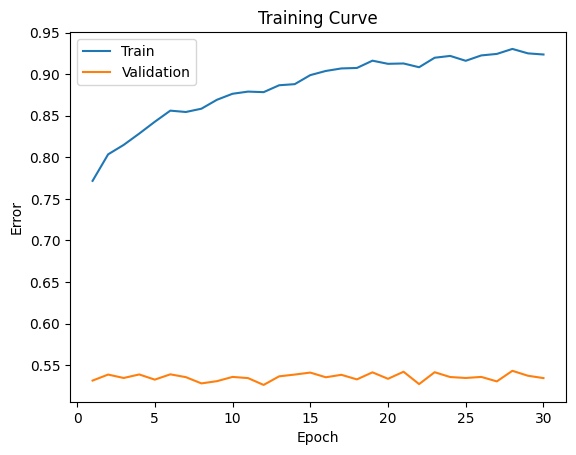

In [ ]:

if use_cuda and torch.cuda.is_available():
  model.cuda()

train(model, train_loader, val_loader, num_epochs = 30)
